<a href="https://colab.research.google.com/github/MargotZhao/machine-learning-project/blob/main/ml_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cd C:\\Users\\zhaos\\Downloads

C:\Users\zhaos\Downloads


In [ ]:
tickets = pd.read_csv('anonymized_hubspot_tickets.csv')
deals = pd.read_csv('anonymized_hubspot_deals.csv')
companies = pd.read_csv('anonymized_hubspot_companies.csv')

C:\Users\zhaos\AppData\Local\Temp\ipykernel_56988\2095908849.py:3: DtypeWarning: Columns (24,25,28,32,45) have mixed types. Specify dtype option on import or set low_memory=False.
  companies = pd.read_csv('anonymized_hubspot_companies.csv')


In [ ]:
# --- Company Size Category ---
def size_category(num_employees):
    if pd.isnull(num_employees):
        return np.nan
    elif num_employees < 10:
        return "Very Small"
    elif num_employees < 50:
        return "Small"
    elif num_employees < 250:
        return "Medium"
    elif num_employees < 1000:
        return "Large"
    else:
        return "Enterprise"

companies['Company_Size_Category'] = companies['Number of Employees'].apply(size_category)

# --- Revenue Category ---
def revenue_category(revenue):
    if pd.isnull(revenue):
        return np.nan
    elif revenue < 1_000_000:
        return "<$1M"
    elif revenue < 10_000_000:
        return "$1M-$10M"
    elif revenue < 50_000_000:
        return "$10M-$50M"
    elif revenue < 100_000_000:
        return "$50M-$100M"
    elif revenue < 500_000_000:
        return "$100M-$500M"
    else:
        return ">$500M"

companies['Revenue_Category'] = companies['Annual Revenue'].apply(revenue_category)

# --- Industry Standardized ---
companies['Industry_Standardized'] = companies['Industry'].str.title()

# --- Region ---
companies['Region'] = companies['Country/Region'].str.strip()

# --- Uses_[Technology] flags ---
technology_keywords = ['Google Tag Manager', 'Salesforce', 'Microsoft Office 365']
for tech in technology_keywords:
    col_name = f'Uses_{tech.replace(" ", "_")}'
    companies[col_name] = companies['Web Technologies'].fillna('').apply(lambda x: int(tech.lower() in x.lower()))

# --- Technology Count ---
companies['Technology_Count'] = companies['Web Technologies'].fillna('').apply(lambda x: len([t for t in x.split(';') if t.strip()]))

# --- Is_BPO flag ---
companies['Is_BPO'] = companies['BPO'].str.lower().map({'yes': 1, 'no': 0})

# --- Date-based Fields ---
companies['Create Date'] = pd.to_datetime(companies['Create Date'], errors='coerce')
companies['Create_Year'] = companies['Create Date'].dt.year
companies['Create_Month'] = companies['Create Date'].dt.month
companies['Create_Quarter'] = companies['Create Date'].dt.quarter
companies['Create_YearMonth'] = companies['Create Date'].dt.to_period('M').astype(str)


In [ ]:
# Clean up column names just in case
tickets.columns = tickets.columns.str.strip()

# --- Convert date columns (only those that exist) ---
date_cols = [
    'Create date', 'Close date', '1st Syms presented for review',
    '1st syms run in production',  # This column may still not exist; remove if needed
]
for col in date_cols:
    if col in tickets.columns:
        tickets[col] = pd.to_datetime(tickets[col], errors='coerce')

# --- Implementation Duration in Days ---
tickets['Implementation_Duration_Days'] = (
    tickets['Close date'] - tickets['Create date']
).dt.days

# --- Days to First Sym ---
tickets['Days_To_First_Sym'] = (
    tickets['1st Syms presented for review'] - tickets['Create date']
).dt.days

# --- Time to Close in Hours ---
def convert_to_hours(x):
    try:
        h, m, s = map(int, str(x).split(':'))
        return h + m/60 + s/3600
    except:
        return np.nan

tickets['Time_To_Close_Hours'] = tickets['Time to close (HH:mm:ss)'].apply(convert_to_hours)

# --- Implementation Status (simplified) ---
status_map = {
    'New': 'Not Started',
    'In Progress': 'Ongoing',
    'Waiting on contact': 'Ongoing',
    'Waiting on us': 'Ongoing',
    'Closed': 'Completed'
}
tickets['Implementation_Status'] = tickets['Ticket status'].map(status_map)

# --- Training Completion Count & Percentage ---
training_cols = [
    'Training: Sym Building 101',
    'Training: Sym Building 201',
    'Training: General Overview',
    'Training: Reporting',
    'Training: Deployment/User Management Training'
]
tickets['Training_Completion_Count'] = tickets[training_cols].notna().sum(axis=1)
tickets['Training_Completion_Pct'] = (tickets['Training_Completion_Count'] / len(training_cols)) * 100

# --- Create Year, Month, YearMonth ---
tickets['Create_Year'] = tickets['Create date'].dt.year
tickets['Create_Month'] = tickets['Create date'].dt.month
tickets['Create_YearMonth'] = tickets['Create date'].dt.to_period('M').astype(str)


In [ ]:
# Strip column names just in case
deals.columns = deals.columns.str.strip()

# --- Parse date columns ---
deals['Create Date'] = pd.to_datetime(deals['Create Date'], errors='coerce')
deals['Close Date'] = pd.to_datetime(deals['Close Date'], errors='coerce')

# --- Create Year/Month/Quarter ---
deals['Create_Year'] = deals['Create Date'].dt.year
deals['Create_Month'] = deals['Create Date'].dt.month
deals['Create_Quarter'] = deals['Create Date'].dt.quarter

deals['Close_Year'] = deals['Close Date'].dt.year
deals['Close_Month'] = deals['Close Date'].dt.month

# --- YearMonth string for time-based grouping ---
deals['YearMonth'] = deals['Create Date'].dt.to_period('M').astype(str)

# --- Deal Size Category ---
def deal_size_category(amount):
    if pd.isnull(amount):
        return None
    elif amount < 10000:
        return "Small"
    elif amount < 50000:
        return "Medium"
    elif amount < 250000:
        return "Large"
    else:
        return "Enterprise"

deals['Deal_Size_Category'] = deals['Amount'].apply(deal_size_category)



In [ ]:
# Drop columns with >95% missing
def drop_high_na_columns(df, threshold=0.95):
    return df.loc[:, df.isnull().mean() <= threshold]

companies_cleaned = drop_high_na_columns(companies)
tickets_cleaned = drop_high_na_columns(tickets)
deals_cleaned = drop_high_na_columns(deals)

# Detect outliers using IQR
def detect_outliers(df):
    outlier_info = {}
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        if not outliers.empty:
            outlier_info[col] = {
                "lower_bound": lower,
                "upper_bound": upper,
                "num_outliers": len(outliers),
                "outlier_indices": outliers.index.tolist()[:5]
            }
    return outlier_info

# Run outlier detection
companies_outliers = detect_outliers(companies_cleaned)
tickets_outliers = detect_outliers(tickets_cleaned)
deals_outliers = detect_outliers(deals_cleaned)


In [ ]:
# Further data cleaning on companies
# 1. Drop rows with missing key segmentation fields
companies_cleaned = companies_cleaned.dropna(subset=['Industry', 'Annual Revenue', 'Number of Employees'])

# 2. Standardize Country/Region
companies_cleaned['Country/Region'] = companies_cleaned['Country/Region'].astype(str).str.strip().str.title()

# 3. Clean Web Technologies field
def clean_web_tech(text):
    if pd.isna(text):
        return []
    return [tech.strip() for tech in text.split(';') if tech.strip()]

companies_cleaned['Web Technologies'] = companies_cleaned['Web Technologies'].apply(clean_web_tech)

# 4. Drop parent/child company relationship fields if present and mostly empty
cols_to_drop = ['Parent Company', 'Associated Company']
companies_cleaned = companies_cleaned.drop(columns=[col for col in cols_to_drop if col in companies_cleaned.columns])


In [ ]:
# 1. Convert time columns to seconds
def time_to_seconds(x):
    try:
        h, m, s = map(int, str(x).split(":"))
        return h * 3600 + m * 60 + s
    except:
        return np.nan

time_columns = ['Time to close (HH:mm:ss)', 'Response time (HH:mm:ss)', 'Time to first agent email reply (HH:mm:ss)']
for col in time_columns:
    if col in tickets_cleaned.columns:
        tickets_cleaned[col + '_seconds'] = tickets_cleaned[col].apply(time_to_seconds)

# 2. Training field completeness (flag if at least one completed)
training_cols = [
    'Training: Sym Building 101',
    'Training: Sym Building 201',
    'Training: General Overview',
    'Training: Reporting',
    'Training: Deployment/User Management Training'
]
for col in training_cols:
    if col in tickets_cleaned.columns:
        tickets_cleaned[col + '_Completed'] = tickets_cleaned[col].notna().astype(int)

# 3. Flag for ongoing implementation (missing milestone allowed)
tickets_cleaned['Is_Closed'] = tickets_cleaned['Ticket status'].str.lower() == 'closed'

# 4. Flag for whether ticket is linked to a deal
tickets_cleaned['Has_Associated_Deal'] = tickets_cleaned['Associated Deal'].notna().astype(int)


C:\Users\zhaos\AppData\Local\Temp\ipykernel_56988\1492899467.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_cleaned[col + '_seconds'] = tickets_cleaned[col].apply(time_to_seconds)
C:\Users\zhaos\AppData\Local\Temp\ipykernel_56988\1492899467.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets_cleaned[col + '_seconds'] = tickets_cleaned[col].apply(time_to_seconds)
C:\Users\zhaos\AppData\Local\Temp\ipykernel_56988\1492899467.py:12: SettingWithCopyWarning: 
A value is trying to be set on 

In [ ]:
# 1. Handle missing Amount values
# Option 1: Drop rows where 'Amount' is missing
deals_cleaned = deals_cleaned[deals_cleaned['Amount'].notna()]

# Option 2 (alternative): Impute with median by Deal Type
# deals_cleaned['Amount'] = deals_cleaned.groupby('Deal Type')['Amount'].transform(lambda x: x.fillna(x.median()))

# 2. Remove outliers in Days to close using IQR
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

if 'Days to close' in deals_cleaned.columns:
    deals_cleaned = remove_outliers_iqr(deals_cleaned, 'Days to close')

# 3. Optional: Bin Deal probability into categories
def bin_probability(p):
    if pd.isna(p):
        return 'Unknown'
    elif p < 0.3:
        return 'Low'
    elif p < 0.7:
        return 'Medium'
    else:
        return 'High'

deals_cleaned['Deal_Probability_Bin'] = deals_cleaned['Deal probability'].apply(bin_probability)


In [ ]:
import json

# Load the mappings file
with open('mappings.json', 'r') as f:
    mappings = json.load(f)

# Get the company-to-deal mappings
company_to_deals = mappings["CompanyToDeals"]

# Reverse the mapping to create a deal-to-company dictionary
# This will give a one-to-one mapping from deal ID to company ID
deal_to_company = {}

for company_id, deal_list in company_to_deals.items():
    for deal_id in deal_list:
        deal_to_company[deal_id] = company_id

# Assuming your deals dataset is already loaded and has a unique ID column
# Convert the deal ID column to string type for mapping
deals_cleaned['Deal Name'] = deals_cleaned['Deal Name'].astype(str)

# Create a company ID column in the deals dataset using the deal_to_company dictionary
deals_cleaned['Company ID'] = deals_cleaned['Deal Name'].map(deal_to_company)

# Convert company Record ID to string for merging
companies_cleaned['Record ID'] = companies_cleaned['Record ID'].astype(str)

# Merge the deals dataframe with the companies dataframe
# Using left join to keep all deals, even if there's no matching company
merged_deals_companies = pd.merge(
    left=deals_cleaned,
    right=companies_cleaned,
    left_on='Company ID',
    right_on='Record ID',
    how='left'
)

# Now you have a merged dataset with deal information and corresponding company information

In [ ]:
print(merged_deals_companies.columns)

Index(['Weighted amount', 'Deal Description',
       'Cumulative time in "BANT Deal. Pain ID'ed (Sales Pipeline)" (HH:mm:ss)',
       'Cumulative time in "Opportunity (Sales Pipeline)" (HH:mm:ss)',
       'Days to close', 'Deal Score', 'Close Date',
       'Deal source attribution 2',
       'Cumulative time in "In Trial - Trial in Progress (Sales Pipeline)" (HH:mm:ss)',
       'Contract Start Date',
       'Cumulative time in "Partner Referrals  (Sales Pipeline)" (HH:mm:ss)',
       'Cumulative time in "Deep Dive. PSP Drafted (Sales Pipeline)" (HH:mm:ss)',
       'Pipeline', 'Record ID_x', 'Forecast category',
       'Original Traffic Source', 'Associated Company', 'Deal owner',
       'Is Closed (numeric)', 'Amount in company currency', 'Deal probability',
       'Associated Company (Primary)', 'Is Closed Won', 'Contract End Date',
       'Last Activity Date', 'Contract Term (Months)', 'Trial Start date',
       'Is closed lost', 'Weighted amount in company currency',
       'Is Deal

In [ ]:
# Code to select only the relevant columns for customer segmentation analysis
relevant_columns = [
    # Company identifiers
    'Company name', 'Record ID_y', 'Associated Company (Primary)',

    # Company demographics
    'Industry', 'Industry_Standardized', 'Number of Employees',
    'Annual Revenue', 'Company_Size_Category', 'Revenue_Category',
    'Country/Region', 'Region', 'BPO',

    # Technology stack (for segmentation)
    'Web Technologies', 'Technology_Count', 'CCaaS', 'LMS System',
    'Uses_Google_Tag_Manager', 'Uses_Salesforce', 'Uses_Microsoft_Office_365',

    # Deal characteristics
    'Amount', 'Total contract value', 'Deal Type', 'Deal Stage',
    'Deal probability', 'Deal Score', 'Is Closed Won', 'Is closed lost',

    # Time-related fields (for churn prediction and activity patterns)
    'Contract End Date', 'Close Date', 'Last Activity Date', 'Last Modified Date_y',
    'Days to close', 'Create Date_y',

    # Agent/usage metrics (value indicators)
    '# of Agents Total', '# of Agents Contracted', 'SymTrain Use Cases'
]

# Keep only the columns that exist in your merged dataset
existing_columns = [col for col in relevant_columns if col in merged_deals_companies.columns]

# Create the filtered dataframe
filtered_df = merged_deals_companies[existing_columns]

# Check for key columns that might be missing
missing_columns = [col for col in relevant_columns if col not in merged_deals_companies.columns]
if missing_columns:
    print(f"Note: The following recommended columns were not found in your dataset: {missing_columns}")

Note: The following recommended columns were not found in your dataset: ['BPO', 'LMS System', 'Total contract value', '# of Agents Total', '# of Agents Contracted', 'SymTrain Use Cases']


In [ ]:
# Define relevant columns for segmentation and prediction
columns_to_keep = [
    # Company identifiers
    'Company name', 'Record ID_y', 'Associated Company (Primary)',

    # Company demographics
    'Industry', 'Industry_Standardized', 'Number of Employees',
    'Annual Revenue', 'Company_Size_Category', 'Revenue_Category',
    'Country/Region', 'Region',

    # Technology stack (for segmentation)
    'Web Technologies', 'Technology_Count', 'CCaaS',
    'Uses_Google_Tag_Manager', 'Uses_Salesforce', 'Uses_Microsoft_Office_365',

    # Deal characteristics
    'Amount', 'Deal Type', 'Deal Stage',
    'Deal probability', 'Deal Score', 'Is Closed Won', 'Is closed lost', 'Is Closed (numeric)',
    'Is Deal Closed?', 'Is Open (numeric)',

    # Time-related fields (for churn prediction and activity patterns)
    'Contract End Date', 'Close Date', 'Last Activity Date', 'Last Modified Date_y',
    'Days to close', 'Create Date_y',
]

# Subset the tickets dataframe
merged_data = merged_deals_companies[columns_to_keep]

In [ ]:
print(merged_data.columns)

Index(['Company name', 'Record ID_y', 'Associated Company (Primary)',
       'Industry', 'Industry_Standardized', 'Number of Employees',
       'Annual Revenue', 'Company_Size_Category', 'Revenue_Category',
       'Country/Region', 'Region', 'Web Technologies', 'Technology_Count',
       'CCaaS', 'Uses_Google_Tag_Manager', 'Uses_Salesforce',
       'Uses_Microsoft_Office_365', 'Amount', 'Deal Type', 'Deal Stage',
       'Deal probability', 'Deal Score', 'Is Closed Won', 'Is closed lost',
       'Is Closed (numeric)', 'Is Deal Closed?', 'Is Open (numeric)',
       'Contract End Date', 'Close Date', 'Last Activity Date',
       'Last Modified Date_y', 'Days to close', 'Create Date_y'],
      dtype='object')


In [ ]:
merged_data.head()

,Company name,Record ID_y,Associated Company (Primary),Industry,Industry_Standardized,Number of Employees,Annual Revenue,Company_Size_Category,Revenue_Category,Country/Region,...,Is closed lost,Is Closed (numeric),Is Deal Closed?,Is Open (numeric),Contract End Date,Close Date,Last Activity Date,Last Modified Date_y,Days to close,Create Date_y
0,NaN,NaN,Associated_9ea45ab3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0.0,False,1.0,NaN,2025-05-01 15:26:00,2025-02-20 14:06,NaN,69.0,NaT
1,NaN,NaN,Associated_77e18366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0.0,False,1.0,NaN,2025-07-20 09:06:00,NaN,NaN,149.0,NaT
2,NaN,NaN,Associated_77e18366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0.0,False,1.0,NaN,2025-07-20 09:03:00,NaN,NaN,149.0,NaT
3,NaN,NaN,Associated_77e18366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0.0,False,1.0,NaN,2025-07-20 08:55:00,NaN,NaN,149.0,NaT
4,NaN,NaN,Associated_edbdb698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0.0,False,1.0,NaN,2025-06-20 15:01:00,2025-02-14 15:30,NaN,120.0,NaT


In [ ]:
high_missing = merged_data.columns[merged_data.isnull().mean() > 0.90]
merged_cleaned = merged_data.drop(columns=high_missing)

In [ ]:
merged_cleaned.columns

Index(['Associated Company (Primary)', 'Amount', 'Deal Type', 'Deal Stage',
       'Deal probability', 'Deal Score', 'Is Closed Won', 'Is closed lost',
       'Is Closed (numeric)', 'Is Deal Closed?', 'Is Open (numeric)',
       'Contract End Date', 'Close Date', 'Last Activity Date',
       'Days to close'],
      dtype='object')

In [ ]:
merged_cleaned.to_csv("merged_cleaned.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the cleaned merged dataset
merged_cleaned = pd.read_csv("merged_cleaned.csv")

# Convert date
merged_cleaned['Last Activity Date'] = pd.to_datetime(merged_cleaned['Last Activity Date'], errors='coerce')
today = pd.Timestamp.today()
merged_cleaned['Recency_Days'] = (today - merged_cleaned['Last Activity Date']).dt.days

# Aggregate deal info to customer level
customer_df = merged_cleaned.groupby('Associated Company (Primary)').agg({
    'Amount': ['sum', 'mean', 'count'],
    'Deal probability': 'mean',
    'Deal Score': 'mean',
    'Is Closed Won': 'sum',
    'Is closed lost': 'sum',
    'Is Open (numeric)': 'sum',
    'Days to close': 'mean',
    'Recency_Days': 'min'
})

# Flatten column names
customer_df.columns = ['_'.join(col).strip() for col in customer_df.columns.values]
customer_df.reset_index(inplace=True)

# Drop missing values
customer_df.dropna(inplace=True)

# Normalize features
features = customer_df.drop(columns=['Associated Company (Primary)'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(scaled_features)



/var/folders/2d/d0kzt8513jx2wgn4ml9fmy0w0000gn/T/ipykernel_53137/159777950.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customer_df, x='Cluster', palette='Set2')


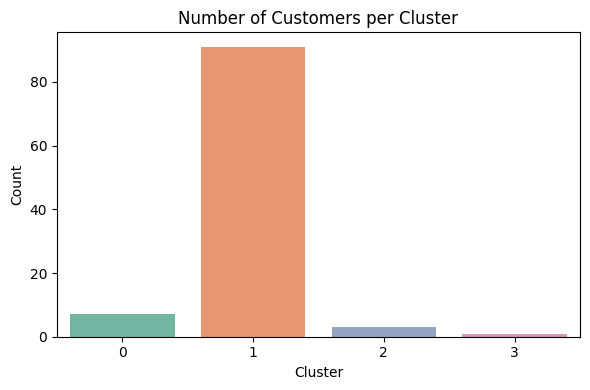

/var/folders/2d/d0kzt8513jx2wgn4ml9fmy0w0000gn/T/ipykernel_53137/159777950.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary.reset_index(), x='Cluster', y='Amount_mean', palette='Set1')


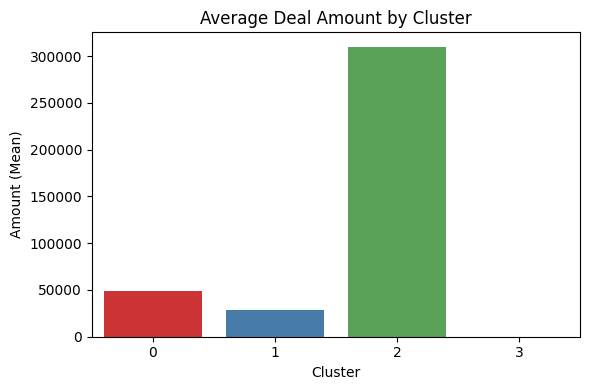

/var/folders/2d/d0kzt8513jx2wgn4ml9fmy0w0000gn/T/ipykernel_53137/159777950.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary.reset_index(), x='Cluster', y='Deal Score_mean', palette='Set3')


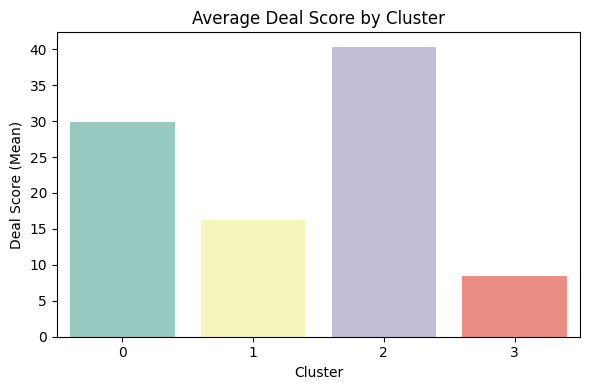

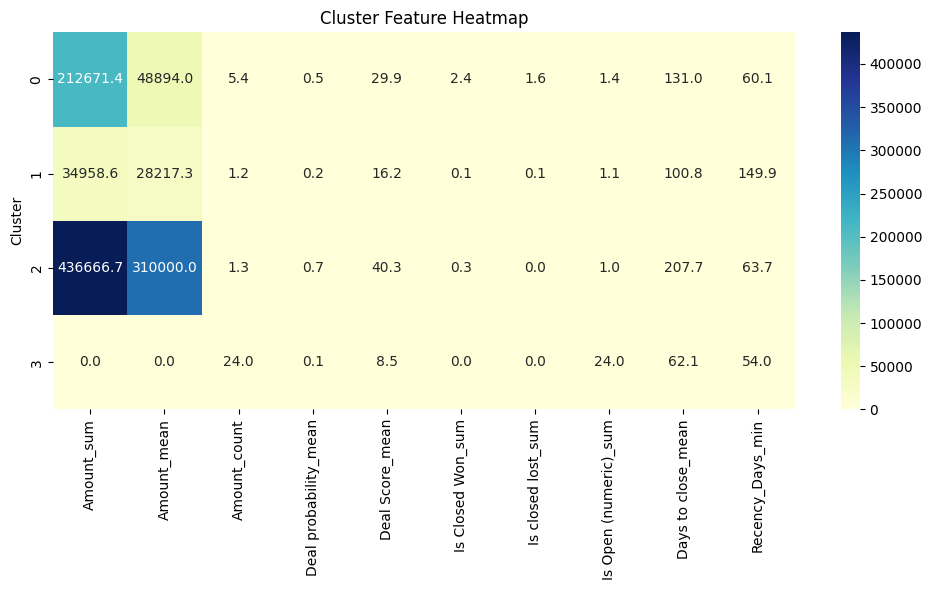

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics by cluster
cluster_summary = customer_df.groupby('Cluster').mean(numeric_only=True)

# Plot 1: Number of customers per cluster
plt.figure(figsize=(6, 4))
sns.countplot(data=customer_df, x='Cluster', palette='Set2')
plt.title("Number of Customers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Plot 2: Average deal amount by cluster
plt.figure(figsize=(6, 4))
sns.barplot(data=cluster_summary.reset_index(), x='Cluster', y='Amount_mean', palette='Set1')
plt.title("Average Deal Amount by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Amount (Mean)")
plt.tight_layout()
plt.show()

# Plot 3: Average deal score by cluster
plt.figure(figsize=(6, 4))
sns.barplot(data=cluster_summary.reset_index(), x='Cluster', y='Deal Score_mean', palette='Set3')
plt.title("Average Deal Score by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Deal Score (Mean)")
plt.tight_layout()
plt.show()

# Plot 4: Cluster heatmap of feature averages
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cluster Feature Heatmap")
plt.tight_layout()
plt.show()


# Sales Insights Modeling Pipeline

This notebook demonstrates an end‐to‐end modeling pipeline for analyzing sales data. It is divided into several sections:

1. **Imports & Helper Functions:** Load required libraries and define helper functions.
2. **ETL Pipeline:** Load and preprocess the merged data.
3. **Clustering Models:** Segment customers using KMeans and DBSCAN.
4. **Classification Models:** Predict deal outcomes using Logistic Regression, Random Forest, and XGBoost.
5. **Interactive Dashboard:** Visualize insights using Streamlit.

Each section is explained below.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st  # For interactive dashboard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Helper function to convert HH:mm:ss to seconds
def hhmmss_to_seconds(time_str):
    """Convert a time string in HH:mm:ss format to total seconds."""
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except Exception:
        return np.nan

## ETL Pipeline
This section loads the CSV file containing the merged data (named `eda_merge_with_clusters.csv`) into a DataFrame (`merged_tickets_deals`). It also performs simple preprocessing:
- Fills missing values.
- Converts time strings (e.g., "Time to close (HH:mm:ss)") to seconds.

In [ ]:
import pandas as pd
my_data=pd.read_csv('merged_cleaned.csv')

In [ ]:
def etl_pipeline(file_path):
    """
    Load and process the merged data.

    - Reads CSV data into a DataFrame named my_data.
    - Fills missing values.
    - Converts "Time to close (HH:mm:ss)" into seconds.
    """

    my_data.fillna(method='ffill', inplace=True)

    # Convert "Time to close (HH:mm:ss)" to seconds if available
    if "Time to close (HH:mm:ss)" in my_data.columns:
        my_data["time_to_close_seconds"] = my_data["Time to close (HH:mm:ss)"].apply(hhmmss_to_seconds)
    else:
        my_data["time_to_close_seconds"] = np.nan

    print("Columns in the dataset:")
    print(my_data.columns.tolist())

    return my_data

my_data = etl_pipeline("merged_cleaned.csv")

Columns in the dataset:
['Associated Company (Primary)', 'Amount', 'Deal Type', 'Deal Stage', 'Deal probability', 'Deal Score', 'Is Closed Won', 'Is closed lost', 'Is Closed (numeric)', 'Is Deal Closed?', 'Is Open (numeric)', 'Contract End Date', 'Close Date', 'Last Activity Date', 'Days to close', 'time_to_close_seconds']


C:\Users\zhaos\AppData\Local\Temp\ipykernel_56988\2887950771.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  my_data.fillna(method='ffill', inplace=True)


## Clustering Models
In this section, we segment the data using two unsupervised clustering techniques:
- **KMeans:** Groups companies based on numeric features such as weighted amount, deal probability, deal score, days to close, and time-to-close (in seconds).
- **DBSCAN:** Provides an alternative clustering method that can identify clusters of arbitrary shape and filter noise.

Adjust the feature list as needed based on your data.

In [ ]:
def clustering_model(my_data):
    """
    Apply clustering to segment companies.

    Features used:
      - 'Deal probability'
      - 'Deal Score'
      - 'Days to close'
    """
    features = ['Deal probability', 'Deal Score', 'Days to close']
    # Drop rows with missing values in the selected features
    X = my_data[features].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- KMeans Clustering ---
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    # Assign clusters to the original DataFrame for rows with valid data
    my_data.loc[X.index, 'kmeans_cluster'] = clusters

    # --- DBSCAN Clustering ---
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    db_clusters = dbscan.fit_predict(X_scaled)
    my_data.loc[X.index, 'dbscan_cluster'] = db_clusters

    return my_data, kmeans, dbscan


my_data, kmeans_model, dbscan_model = clustering_model(my_data)

# Cluster counts
print("KMeans cluster counts:")
print(my_data['kmeans_cluster'].value_counts())

print("\nDBSCAN cluster counts:")
print(my_data['dbscan_cluster'].value_counts())

# KMeans inertia
print("\nKMeans Inertia:", kmeans_model.inertia_)

KMeans cluster counts:
kmeans_cluster
1.0    309
2.0    109
0.0     90
Name: count, dtype: int64

DBSCAN cluster counts:
dbscan_cluster
 1.0    180
 0.0    144
 3.0    104
-1.0     49
 2.0     24
 4.0      7
Name: count, dtype: int64

KMeans Inertia: 829.5309984136272


In [ ]:
print(merged_cleaned.columns.tolist())

['Associated Company (Primary)', 'Amount', 'Deal Type', 'Deal Stage', 'Deal probability', 'Deal Score', 'Is Closed Won', 'Is closed lost', 'Is Closed (numeric)', 'Is Deal Closed?', 'Is Open (numeric)', 'Contract End Date', 'Close Date', 'Last Activity Date', 'Days to close', 'Recency_Days']


## Classification Models
Here we build classification models to predict deal outcomes. We assume that the binary target column `Is Closed Won` exists in the data.
The models used are:
- **Logistic Regression:** A linear model for binary classification.
- **Random Forest:** An ensemble method that builds multiple decision trees.
- **XGBoost:** A gradient boosting model optimized for performance.

The feature set is the same as used in clustering, and we drop rows with missing values.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def classification_model_log_reg(my_data):
    features = ['Amount', 'Deal Score', 'Days to close']

    # Drop rows missing any of the features or target
    data = my_data[features + ['Is Closed (numeric)']].dropna()
    X = data[features]
    y = data['Is Closed (numeric)']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features for models that require scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Logistic Regression ---
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train_scaled, y_train)
    y_pred = log_reg.predict(X_test_scaled)

    # Print evaluation results
    print("\n--- Logistic Regression ---")
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return log_reg, (X_test_scaled, y_test), y_pred

# Call the logistic regression function to see output
results_log = classification_model_log_reg(my_data)


--- Logistic Regression ---
Accuracy: 0.7352941176470589
              precision    recall  f1-score   support

         0.0       0.65      0.49      0.56        35
         1.0       0.76      0.87      0.81        67

    accuracy                           0.74       102
   macro avg       0.71      0.68      0.68       102
weighted avg       0.73      0.74      0.72       102

Confusion Matrix:
 [[17 18]
 [ 9 58]]


In [ ]:
# Predict whether the deal will be successful
my_data['Prediction'] = results_log[0].predict(my_data[['Amount', 'Deal Score', 'Days to close']])

# Predict probabilities for the success of the deal
my_data['Success_Probability'] = results_log[0].predict_proba(my_data[['Amount', 'Deal Score', 'Days to close']])[:, 1]

# Display the first few rows of the results
print(my_data[['Amount', 'Deal Score', 'Days to close', 'Prediction', 'Success_Probability']].head())

    Amount  Deal Score  Days to close  Prediction  Success_Probability
0   1250.0        33.0           69.0         1.0         1.000000e+00
1      0.0        13.0          149.0         1.0         1.000000e+00
2      0.0        13.0          149.0         1.0         1.000000e+00
3      0.0        13.0          149.0         1.0         1.000000e+00
4  50000.0        37.0          120.0         0.0        5.652386e-282


C:\Users\zhaos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\zhaos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 特征和标签
features = ['Amount', 'Deal Score', 'Days to close']

# 清理数据
data = my_data[features + ['Is Closed (numeric)']].dropna()
X = data[features]
y = data['Is Closed (numeric)']

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分训练测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# --- Random Forest ---
results_rf = RandomForestClassifier(n_estimators=50, max_depth=3, min_samples_leaf=5,random_state=42)
results_rf.fit(X_train, y_train)
y_pred_rf = results_rf.predict(X_test)

print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))



--- Random Forest ---
Accuracy: 0.9019607843137255
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82        29
         1.0       0.92      0.95      0.93        73

    accuracy                           0.90       102
   macro avg       0.89      0.87      0.88       102
weighted avg       0.90      0.90      0.90       102

Confusion Matrix:
 [[23  6]
 [ 4 69]]


In [ ]:
# Predict whether the deal will be successful
predictions = results_rf.predict(my_data[features])

# Predict probabilities for the success of the deal
success_probabilities = results_rf.predict_proba(my_data[features])[:, 1]  # Probability of the positive class (success)

# Add the predictions and probabilities to the original data for better analysis
my_data['Prediction'] = predictions
my_data['Success_Probability'] = success_probabilities

# Display the first few rows of the results
print(my_data[['Amount', 'Deal Score', 'Days to close', 'Prediction', 'Success_Probability']].head())

    Amount  Deal Score  Days to close  Prediction  Success_Probability
0   1250.0        33.0           69.0         1.0             0.567443
1      0.0        13.0          149.0         1.0             0.632337
2      0.0        13.0          149.0         1.0             0.632337
3      0.0        13.0          149.0         1.0             0.632337
4  50000.0        37.0          120.0         1.0             0.567443


C:\Users\zhaos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\zhaos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Helper function to print the classification report and confusion matrix
def print_cv_classification_output(model_name, y_true, y_pred):
    accuracy = np.mean(y_pred == y_true)
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}\n")
    print(classification_report(y_true, y_pred, digits=2))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print()

# Define feature list
features = ['Amount', 'Deal Score', 'Days to close']

# Optionally include 'cluster' if it exists in the my_data DataFrame
if 'cluster' in my_data.columns:
    features.append('cluster')

# Extract features and target from my_data, and remove rows where the target is missing.
X = my_data[features]
y = my_data['Is Open (numeric)']

# Keep only rows where y is not missing, and cast y to integer.
valid_rows = y.notna()
X = X[valid_rows]
y = y[valid_rows].astype(int)

# Define the XGBoost pipeline
pipeline_xgb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=20,       # Fewer trees for faster training
        max_depth=3,           # Shallower trees to reduce overfitting
        learning_rate=0.1,
        eval_metric='logloss',
        objective='binary:logistic',  # Binary classification objective
        random_state=42,
        verbosity=0            # Suppress messages
    ))
])

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate out-of-fold predictions using cross_val_predict
results_xgb = cross_val_predict(pipeline_xgb, X, y, cv=cv)

# Print the combined cross-validated classification report and confusion matrix for XGBoost
print_cv_classification_output("XGBoost (5-fold CV)", y, results_xgb)

--- XGBoost (5-fold CV) ---
Accuracy: 0.89

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       362
           1       0.78      0.84      0.81       146

    accuracy                           0.89       508
   macro avg       0.86      0.87      0.86       508
weighted avg       0.89      0.89      0.89       508

Confusion Matrix:
[[328  34]
 [ 24 122]]



In [ ]:
# Fit the pipeline before making predictions
pipeline_xgb.fit(X, y)

# Predict whether the deal will be successful using the trained pipeline
predictions = pipeline_xgb.predict(my_data[features])

# Predict probabilities for the success of the deal
success_probabilities = pipeline_xgb.predict_proba(my_data[features])[:, 1]  # Probability of the positive class (success)

# Add the predictions and probabilities to the original data for better analysis
my_data['Prediction'] = predictions
my_data['Success_Probability'] = success_probabilities

# Display the first few rows of the results
print(my_data[['Amount', 'Deal Score', 'Days to close', 'Prediction', 'Success_Probability']].head())

    Amount  Deal Score  Days to close  Prediction  Success_Probability
0   1250.0        33.0           69.0           1             0.522089
1      0.0        13.0          149.0           1             0.876969
2      0.0        13.0          149.0           1             0.876969
3      0.0        13.0          149.0           1             0.876969
4  50000.0        37.0          120.0           0             0.074557
